In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
%config InlineBackend.figure_format = 'retina'

# numerical methods 

In [2]:
def xy_to_rtheta(x, y):
    """
    takes in cartesian coordinates and returns them as polar coordinates
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def rtheta_to_xy(r, theta):
    """
    takes in polar coordinates and returns them as cartesian coordinates
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def v_polar_to_v_cart(u_r, u_theta):
    u = u_r * np.cos(theta) - u_theta * np.sin(theta)
    v = u_r * np.sin(theta) + u_theta * np.cos(theta)
    return u, v

def find_laplacian(f, dx, dy):
    
    dfdy, dfdx = np.gradient(f)
    dfdx = dfdx/dx
    dfdy = dfdy/dy

    d2fdydx, d2fdx2 = np.gradient(dfdx)
    d2fdx2 = d2fdx2/dx


    d2fdy2, d2fdxdy = np.gradient(dfdy)
    d2fdy2 = d2fdy2/dy

    laplacian = d2fdx2 + d2fdy2
    return laplacian

def find_div(u, v, dy, dx):
    #Computes gradient of u - This has two components
    dudy,dudx = np.gradient(u) 

    # Computes gradient of v - This has two components
    dvdy,dvdx = np.gradient(v) 

    dudy = dudy/dy
    dudx = dudx/dx

    dvdy = dvdy/dy
    dvdx = dvdx/dx

    #This computes the divergence using dudx and dvdy
    div_uv = dudx + dvdy 
    return div_uv

def find_curl(u, v, dy, dx):
    #Computes gradient of u - This has two components
    dudy,dudx = np.gradient(u) 

    # Computes gradient of v - This has two components
    dvdy,dvdx = np.gradient(v) 

    dudy = dudy/dy
    dudx = dudx/dx

    dvdy = dvdy/dy
    dvdx = dvdx/dx

    #This computes the divergence using dudx and dvdy
    curl_uv = dvdx - dudy 
    return curl_uv

In [3]:
#The input for this function is the streamfunction
def findvelocities(psi):
    #This command computes the w and u components of velocity as gradient(psi)
    #As seen earlier, the gradient along the columns is taken in first and then the rows...
    #The function gradient computes the first derivative of a variable along a given axis. 
    u,w = np.gradient(psi)
    
    u = u/dz
    w = -1*w/dx 
    
    return [u,w]

def findpressure(u,w,Uref):
     #This command computes the pressure coefficient from the dynamic pressure
    Cp = 1-((u**2+w**2)/Uref**2) 
    return Cp

#The input are Uinf and angle alpha (alpha is in degrees)
def uniform_flow(Uinf,alpha):
   #This command is the stream function for Uniform flow
    psiu = Uinf*np.cos(np.pi*alpha/180)*z - Uinf*np.sin(np.pi*alpha/180)*x 
    
    return psiu

#The input to this function is the strength and the location (x0,y0) of source/sink
def source(Q,x0,z0):
    #This command finds the radial coordinate r from the cartesian coordinate
    #relative to this specific flow element
    r = np.sqrt((x-x0)**2+(z-z0)**2) 
    
    #This command finds the tangential angle theta from the cartesian coordinate
    #relative to this specific flow element
    theta = np.arctan2(z-z0,x-x0) 
    
    #This command is the stream function for source/sink
    psis = Q*theta/(2*np.pi) 
    
    return psis

#The input to this function is the strength and the location (x0,y0) of the doublet
def doublet(Kappa,x0,z0):
    #This command finds the radial coordinate r from the cartesian coordinate
    #relative to this specific flow element
    r = np.sqrt((x-x0)**2+(z-z0)**2) 
    
    #This command finds the tangential angle theta from the cartesian coordinate
    #relative to this specific flow element
    theta = np.arctan2(z-z0,x-x0) 
    
    #This command is the stream function for source/sink 
    psid = -Kappa*(z-z0)/(2*np.pi*r*r) 
    
    return psid

#The input to this function is the circulation and the location (x0,y0) of the vortex
def vortex(Gamma,x0,z0):
    
    #This command finds the radial coordinate r from the cartesian coordinate
    #relative to this specific flow element
    r = np.sqrt((x-x0)**2+(z-z0)**2) 
    
    #This command finds the tangential angle theta from the cartesian coordinate
    #relative to this specific flow element
    theta = np.arctan2(z-z0,x-x0)  
    
    #This command is the stream function for a vortex
    psiv = Gamma*np.log(r)/(2*np.pi) 
    return psiv

In [4]:
def foil_alpha(xc, alpha=6):
    gradient = np.tan(np.radians(alpha))
    
    y = xc.copy()
    y[np.where(y<=0.25)] = 0.25 * (xc[np.where(xc<=0.25)]-(2*np.power(xc[np.where(xc<=0.25)], 2)))
    y[np.where(0.25<y)] = (1/36) * (1+xc[np.where(0.25<xc)] - (2*np.power(xc[np.where(0.25<xc)], 2)))
    
    y += xc * gradient
    
    return y

def find_an(f, n):
    dthing = 0.0001
    thing = np.arange(0, np.pi+dthing, dthing)
    
    return np.trapz(f(thing, alpha = 0) * np.cos(np.pi * thing*n), thing)

def foil_theta(theta, alpha=6):
    y=theta.copy()
    y[np.where(y<(np.pi/3))] = 0.25 * (((1-np.cos(theta[np.where(theta<(np.pi/3))]))/2) - (2 * np.power(((1-np.cos(theta[np.where(theta<(np.pi/3))]))/2), 2)))
    y[np.where((np.pi/3)<y)] = (1/36) * (1+((1-np.cos(theta[np.where((np.pi/3)<y)]))/2) - (2 * np.power(((1-np.cos(theta[np.where((np.pi/3)<y)]))/2), 2)))
    
    gradient = np.tan(np.radians(alpha))
    y += theta/np.pi * gradient
    #y += theta * gradient
    
    return y

# 1i

In [5]:
# constants given in the question
rho_air = 1.225
nu_air = 1.5e-5


# get the data from the csv into numpy arrays
data = pd.read_csv("file2.csv")
y_dim = data["y (mm)"]
u_dim = data["U (m/s)"]

# non-dimensionalising u
u_inf = u_dim.max()
u = np.array(u_dim/u_inf)

delta = np.interp(0.99, u, y_dim)
y = np.array(y_dim/delta)

# uncomment to visually check if numbers look right, removed for space
"""
plt.plot(u_dim, y_dim, marker="x", linestyle="--")
plt.xlabel(r"$\frac{u}{U_\infty}$")
plt.ylabel(r"$\frac{y}{\delta}$")
"""

print(f"boundary layer thickness is {delta}mm")
print(f"99% of the freestream velocity is {np.interp(0.99, u, u_dim)}")

boundary layer thickness is 21.99804081632653mm
99% of the freestream velocity is 14.85


# 1ii

In [6]:
# calculating displacement thickness with the different equations stated
disp_1 = np.trapz(1-u, y_dim)
disp_2 = np.trapz(1-u, y) * delta

print(f"displacement thickness is {disp_1}mm")
print(f"The difference between the methods of calculation is {disp_1 - disp_2}mm, so can be ignored")

displacement thickness is 2.707945866666667mm
The difference between the methods of calculation is 4.440892098500626e-16mm, so can be ignored


In [7]:
# calculating momentum thickness with the different equations stated
momt_3 = np.trapz(u*(1-u), y_dim)
momt_4 = np.trapz(u*(1-u), y) * delta

print(f"displacement thickness is {momt_3}mm")
print(f"The difference between the methods of calculation is {momt_3 - momt_4}mm, so can be ignored")

displacement thickness is 2.0912061173688885mm
The difference between the methods of calculation is -4.440892098500626e-16mm, so can be ignored


# 1iii

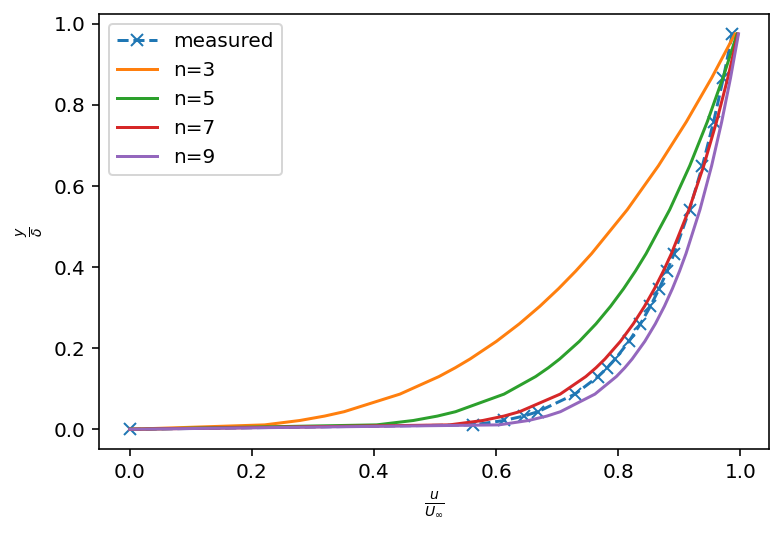

In [8]:
# this will make code more clean
def turb(y, n):
    """
    calculates a model for u/U_inf
    """
    power = 1/n
    return np.power(y, power)

# plot the measured data up to the boundary layer
y_plot = y[np.where(y<1)]
plt.plot(u[np.where(u<1)], y_plot, label = "measured", marker="x", linestyle="--")

# try a few versions to save messing with the data later
n_to_try = [3, 5, 7, 9]
for n in n_to_try:
    plt.plot(turb(y_plot, n), y_plot, label = f"n={n}")

# give the plot labels    
plt.xlabel(r"$\frac{u}{U_\infty}$")
plt.ylabel(r"$\frac{y}{\delta}$")
plt.legend()

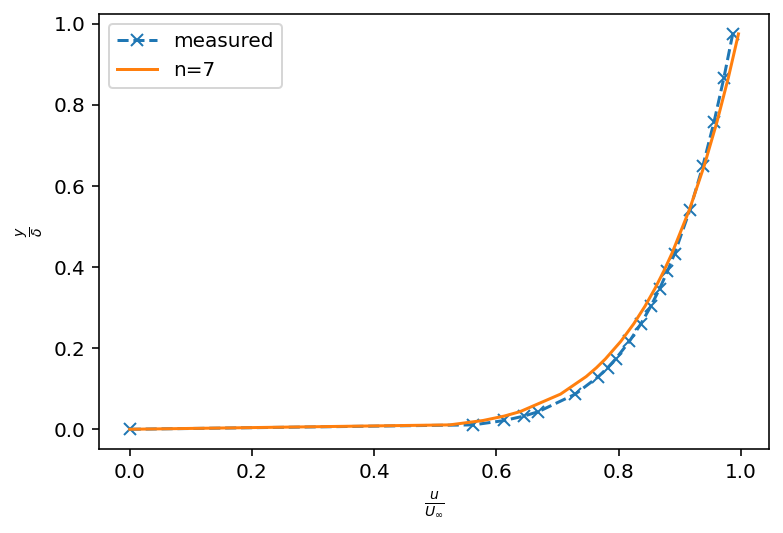

In [9]:
# make a plot only showing the important values
n = 7
plt.plot(u[np.where(u<1)], y_plot, label = "measured", marker="x", linestyle="--")
plt.plot(turb(y_plot, n), y_plot, label = f"n={n}")

# give the plot labels    
plt.xlabel(r"$\frac{u}{U_\infty}$")
plt.ylabel(r"$\frac{y}{\delta}$")
plt.legend()

# 1iv

In [10]:
# re-using equation 4 with the new boundary layer thickness
delta_te = 30
momt_te = np.trapz(u*(1-u), y) * delta_te

# equation 5
drag_te  = momt_te * rho_air * np.power(u_inf, 2)

print(f"drag at the trailing edge for one side is {drag_te}N, so both sides is {drag_te*2}N")

drag at the trailing edge for one side is 786.0545731036401N, so both sides is 1572.1091462072802N


# 1v

In [11]:
def Re(x):
    """
    this is used for reynolds number because everything else is fixed
    """
    return u_inf * x/nu_air
    
def momt_lam(x, Re_t=750000):
    """
    laminar momentum thickness, default value is the transition reynolds number
    """
    return (0.664 * x)/np.power(Re_t, 0.5)

def momt_turb(x):
    """
    turbulent momentum thickness, doesnt need a reynolds number because it can be calculated
    """
    return (0.037* x)/np.power(Re(x), 0.2)

def difference(x_0, x_t = 0.75):
    """
    gets the difference between laminar and turbulent momentum thicknesses for use with fsolve
    """
    return momt_lam(x_t) - momt_turb(x_t - x_0)

In [12]:
# finding how far the virtual origin is from the leading edge of the plate
x_o = optimize.fsolve(difference, 0.5)[0]
print(f"the virtual origin is {x_o}m from the leading edge")

the virtual origin is 0.5764713317680504m from the leading edge


In [13]:
def find_x(x):
    """
    used with fsolve to find the value of x for the momentum thickness found in 1ii
    """
    return momt_turb(x) - momt_3*1e-3

In [14]:

distance = optimize.fsolve(find_x, 0.3)[0]
print(f"the measurements were taken {distance}m from the virtual origin")
print(f"this means {distance + x_o}m from the leading edge")

the measurements were taken 0.8714528524074626m from the virtual origin
this means 1.447924184175513m from the leading edge


# 2i

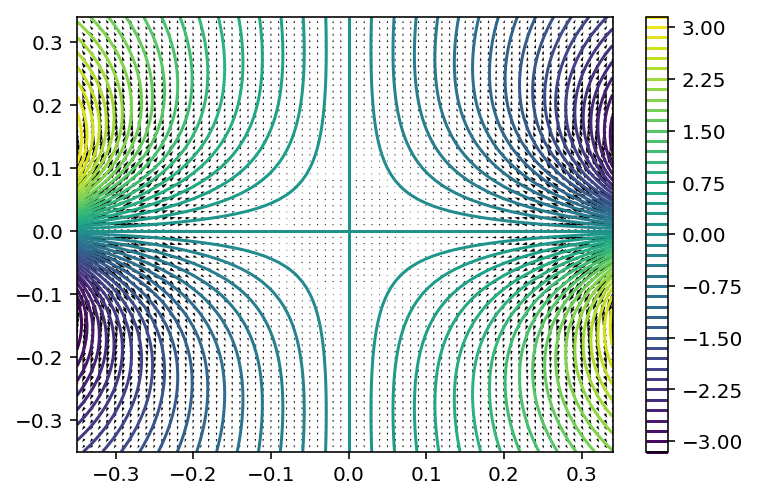

In [15]:
dx=dz=0.01
xa = np.arange(-0.35, 0.35, dx)
za = np.arange(-0.35, 0.35, dz)
x, z = np.meshgrid(xa, za)


kappa = 2 * np.pi
a=0.5

psi = doublet(kappa, a, 0) + doublet(-kappa, -a, 0)
psi = -z/(z**2 + (x-0.5)**2) + z/(z**2 + (x+0.5)**2)
[u,w] = findvelocities(psi)

plt.contour(x, z, psi, levels=50)
plt.colorbar()
plt.quiver(x, z, u, w)

# 2ii

In [16]:
u_ref = kappa/(2*np.pi*np.power(a, 2))

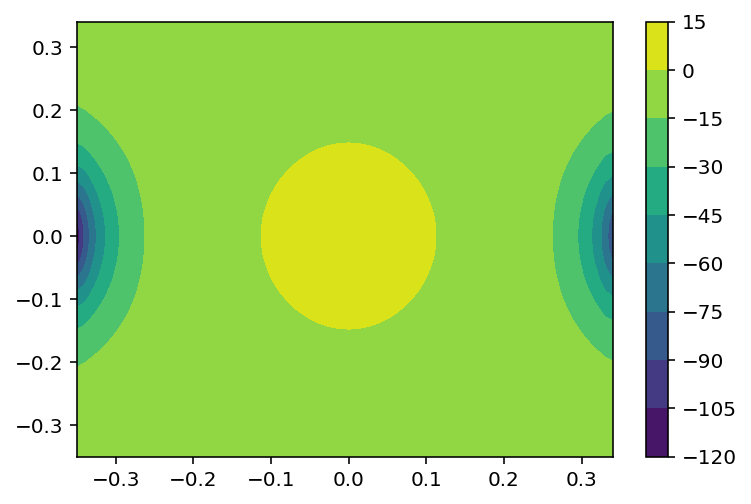

In [17]:
plt.contourf(x, z, findpressure(u, w, u_ref))
plt.colorbar()

In [18]:
u_ref

4.0

# 2iii

Text(0, 0.5, '$C_p$')

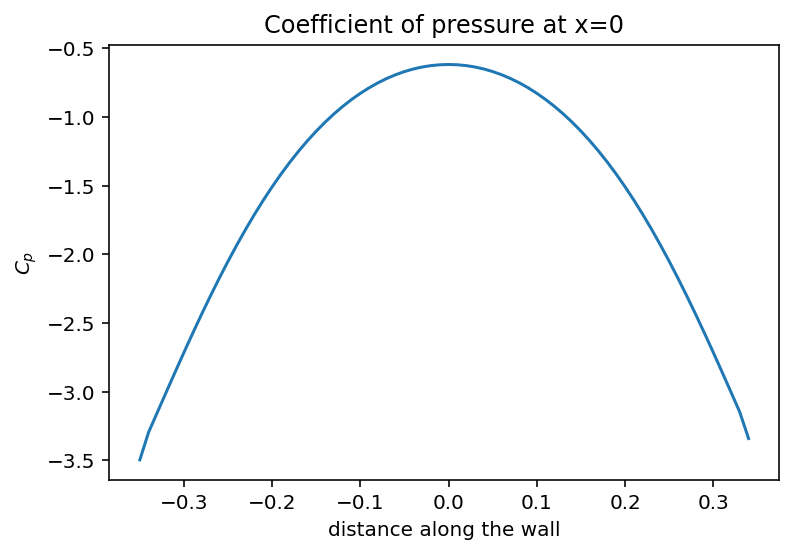

In [19]:
idx = np.where(xa>=0)[0]
#The very first element of this vector should be where x = 0
wall_index = idx[0]
Cp=findpressure(u, w, u_ref)
plt.plot(za, Cp[:wall_index,][1])
plt.title("Coefficient of pressure at x=0")
plt.xlabel("distance along the wall")
plt.ylabel(r"$C_p$")

Text(0, 0.5, 'w')

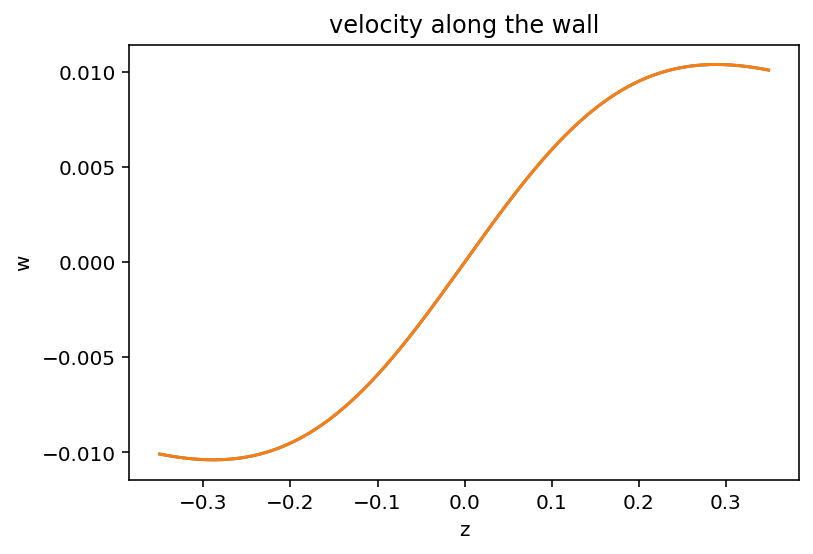

In [20]:
xa=np.linspace(-0.00001,0.00001, 2)
za=np.arange(-0.35, 0.35, 0.001)
x, z = np.meshgrid(xa, za)
psi = -z/(z**2 + (x-0.5)**2) + z/(z**2 + (x+0.5)**2)
[u, w] = findvelocities(psi)
plt.plot(z, w)
plt.title("velocity along the wall")
plt.xlabel("z")
plt.ylabel("w")

# b1ii

In [37]:
def z(x, c=10, epsilon=0.2):
    return x * epsilon * (1-(x/c))

def z_theta(theta, c=10, epsilon=0.2):
    return (epsilon * (c/2) * (1-np.cos(theta)) * (1- (1-np.cos(theta))/2))

def find_An(f, n):
    dthing = 0.0001
    thing = np.arange(0, 10, dthing)
    
    return np.trapz(f(thing) * np.cos(np.pi * thing*n), thing)

alpha = 5
epsilon = 0.2
c=10

In [39]:
x=np.linspace(0, 10)
(1/np.pi) * np.trapz(np.gradient(z(x), x) * x/c, x)

-0.1060591041012214

In [23]:
theta = np.linspace(0, np.pi)
foil_theta = z_theta(theta, c, epsilon)
foil_grad = np.gradient(foil_theta)
(1/np.pi) *np.trapz(foil_grad * (1-np.cos(theta)), theta)

-0.01359612582774193

# B1 ii

In [24]:
a0 = find_An(z, 0)
a1 = find_An(z, 1)
a2 = find_An(z, 2)
np.pi/4 * (a2-a1)

0.023873241463784403

# B1 iii

In [25]:
a2

-0.010132119697556998

13.853369481462035

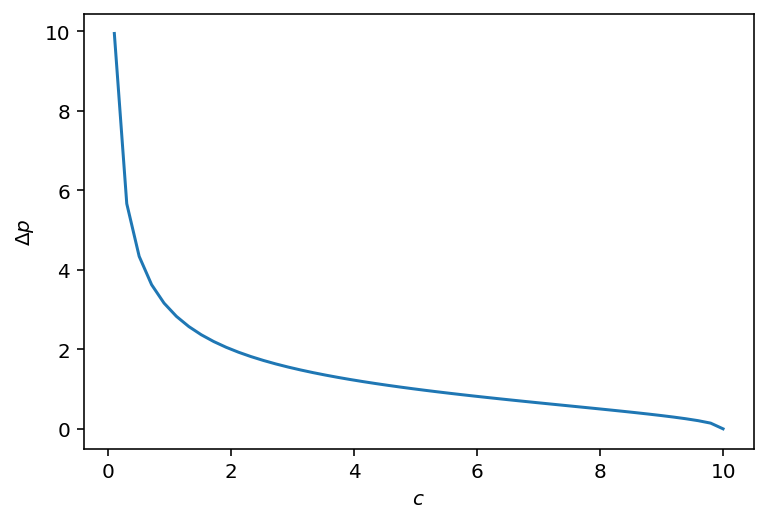

In [26]:
def gamma(x, c, alpha):
    frac = (c-x)/x
    return 0.2*alpha*np.sqrt(frac)

x=np.linspace(0.1, c)
plt.plot(x, gamma(x, c, 5))
plt.xlabel(r"$c$")
plt.ylabel(r"$\Delta p$")
np.trapz(gamma(x, c, 5), x)

# B2i

In [27]:
p=200e3
u_inf = 60
b=8
c=4
cl=0.4
tau=0.2
s=b*c
rho = 1.225

AR = b/c

In [28]:
a = 2*np.pi/(1+ (2*np.pi/(np.pi*AR)))

In [29]:
ai = 0.4/(np.pi * AR)

In [30]:
(cl/a) + ai

0.1909859317102744

In [31]:
d = p/u_inf

In [32]:
c_di = np.power(cl, 2)/(np.pi * AR)
d_i = 0.5 * rho * np.power(u_inf, 2) * s *c_di

In [33]:
d_i

1796.7956455302622

In [34]:
d_i/d

0.5390386936590786